# week 4
청원 주제 분류하는 FINE-TUNE TASK

In [1]:
device = 'cuda'
with open('../data/petitions_2019-01.txt', 'r') as f:
    corpus = f.readlines()
json_list = [eval(json.strip()) for json in corpus]
corpus = [(json['content'], json['category']) for json in json_list]

# base line

# data preprocess

In [2]:
import re
import mecab
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

import torchtext
import sys
sys.path.append('../source')
from dataset import *
from txt_cleaner.clean.master import MasterCleaner
from txt_cleaner.utils import *
from torch8text.data import Vocab, Field, LabelField
from torch.utils.data import Dataset, DataLoader


In [3]:
config = read_yaml('../config.yaml')
petition_ds = PetitionDataset_finetune(config)
petition_ds = petition_ds(corpus)

{'MINIMUM_SPACE_COUNT': 2, 'TOKEN_MAX_LEN': 40, 'CHR_MAX_LEN': 4, 'BATCH_SIZE': 64, 'TOKEN_MIN_FREQ': 5, 'CHR_MIN_FREQ': 1}
20951 20951


In [4]:
petition_dl = DataLoader(petition_ds, batch_size=4, collate_fn=pad_collate_finetune)

In [5]:
# for _ in petition_dl:
#     pass
# #     print(_.src_chr.shape)
# #     print(_.trg)
# #     break

In [6]:
INPUT_DIM = len(petition_ds.chr_field.vocab.stoi_dict)
OUTPUT_DIM = len(petition_ds.label_field.vocab.stoi_dict)
N_LAYERS = 2
HID_DIM = 512
EMBEDDING_DIM = 1024

In [7]:
class simpleGRU_model(nn.Module):
    def __init__(self, input_dim, embedding_dim, n_layers, hid_dim, output_dim):
        super(simpleGRU_model, self).__init__()
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hid_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hid_dim, output_dim)
        
    def forward(self, x):
        bs = x.shape[0]
        output = self.embedding(x)
        output = output.reshape(bs, -1, self.embedding_dim)
        _, output = self.gru(output)
        output = self.fc(output[-1, :, :])
        return output

In [8]:
simple_gru = simpleGRU_model(INPUT_DIM, EMBEDDING_DIM, N_LAYERS, HID_DIM, OUTPUT_DIM)

In [9]:
petition_ds.label_field.vocab.stoi_dict

{'미래': 0,
 '정치개혁': 1,
 '기타': 2,
 '육아/교육': 3,
 '경제민주화': 4,
 '인권/성평등': 5,
 '외교/통일/국방': 6,
 '반려동물': 7,
 '문화/예술/체육/언론': 8,
 '보건복지': 9,
 '저출산/고령화대책': 10,
 '행정': 11,
 '성장동력': 12,
 '교통/건축/국토': 13,
 '일자리': 14,
 '안전/환경': 15,
 '농산어촌': 16}

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_gru.parameters(), lr = config['TRAIN']['LR'])

In [11]:
for _ in petition_dl:
    output = simple_gru(_.src_chr)
    loss = criterion(output, _.trg)
    loss.backward()
    optimizer.step()
    break

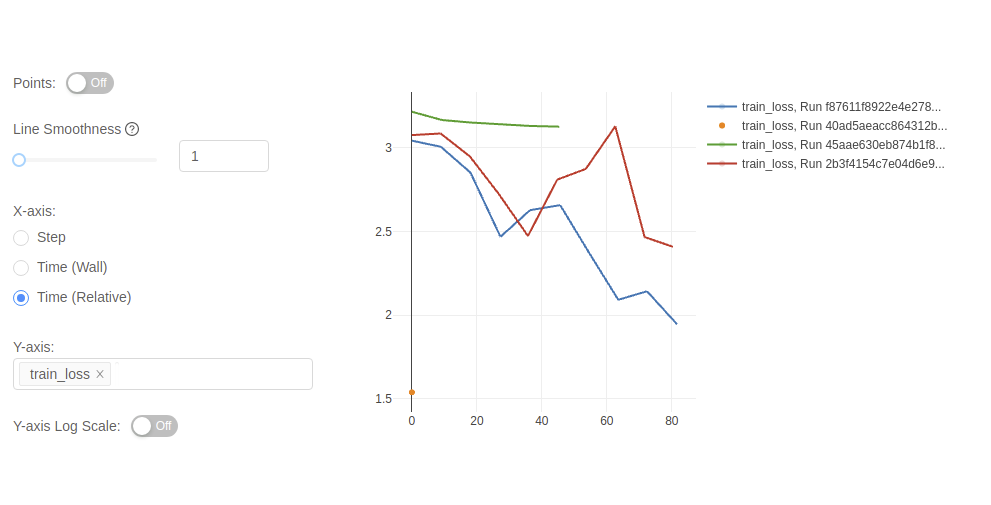

# pretrained model loading 

In [12]:
PATH = '/home/long8v/torch_study/paper/05_ELMo/source/lightning_logs/version_55/checkpoints/epoch=34-step=85224.ckpt'


In [13]:
import mlflow
from utils import *
from model import *
from dataset import *
from torch8text import *
import torch
from utils import *
from model import *
from dataset import *
from torch8text import *

In [14]:
config_file = '/home/long8v/torch_study/paper/05_ELMo/config.yaml'
config = read_yaml(config_file)

In [15]:
with open('../data/petitions.p', 'rb') as f:
    corpus = pickle.load(f)

In [16]:
config = config
ds = PetitionDataset(config)
ds = ds(corpus)
dl = DataLoader(ds, config['DATA']['BATCH_SIZE'], collate_fn=pad_collate)

chr_vocab_size = len(ds.chr_field.vocab)
chr_pad_idx = ds.chr_field.vocab.stoi_dict['<PAD>']
trg_pad_idx = ds.token_field.vocab.stoi_dict['<PAD>']
predict_dim = len(ds.token_field.vocab) 
elmo = ELMo(config, chr_vocab_size, chr_pad_idx, trg_pad_idx, predict_dim)

{'MINIMUM_SPACE_COUNT': 2, 'TOKEN_MAX_LEN': 40, 'CHR_MAX_LEN': 4, 'BATCH_SIZE': 64, 'TOKEN_MIN_FREQ': 5, 'CHR_MIN_FREQ': 1}
cnn_output_dim 30


In [17]:
model = elmo
optimizer, _ = elmo.configure_optimizers()

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['state_dict'])
epoch = checkpoint['epoch']

In [121]:
# (torch.load('../source/model.pt'))

In [18]:
model.eval()
query = '저는 억울합니다. 제가 바로 이 땅의 주인입니다. 반갑습니다.'
token_query = petition_ds.token_field.preprocess(query)
print(token_query)
chr_token_query = petition_ds.chr_field.preprocess(token_query)
print(chr_token_query)
processed_query = petition_ds.chr_field.pad_process(chr_token_query, max_len=40)

['저', '는', '억울', '합니다', '.', '제', '가', '바로', '이', '땅', '의', '주인', '입니다', '.', '반갑', '습니다', '.']
[['저'], ['는'], ['억', '울'], ['합', '니', '다'], ['.'], ['제'], ['가'], ['바', '로'], ['이'], ['땅'], ['의'], ['주', '인'], ['입', '니', '다'], ['.'], ['반', '갑'], ['습', '니', '다'], ['.']]


# elmo + fine-tune task

In [19]:
INPUT_DIM = len(ds.chr_field.vocab.stoi_dict)
OUTPUT_DIM = len(petition_ds.label_field.vocab.stoi_dict)
N_LAYERS = 2
HID_DIM = 512
EMBEDDING_DIM = 1024

In [176]:
class simpleGRU_model_w_elmo(nn.Module):
    def __init__(self, elmo, input_dim, embedding_dim, n_layers, hid_dim, output_dim):
        super(simpleGRU_model_w_elmo, self).__init__()
        self.elmo = elmo
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hid_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hid_dim, output_dim)
        self.n_layers = n_layers
        
    def forward(self, x):
        
        ### get_ elmo vector ###
        # x : batch_size, max_token_len, max_chr_len
        bs = x.shape[0]
        with torch.no_grad():
            forward_hidden, backward_hidden = elmo.forward(x, finetune=True)
        # forward_hidden : seq_len, batch, hidden_size
        elmo_vector = torch.stack([forward_hidden, backward_hidden])   
        
        ### another rnn ### 
        # elmo_vector : 2, seq_len, batch, hidden_dim
        output = self.embedding(x)
        # output : batch_size, seq_len, max_chr_len, embedding_dim
        elmo_vector = elmo_vector.permute(2, 1, 0, 3)
        output = torch.cat([elmo_vector, output], dim = 2)
        # output : batch_size ,seq_len, max_chr_len + 2, embedding_dim
        seq_len =  output.shape[1]
        output = output.reshape(bs, -1, self.embedding_dim)
        _, output = self.gru(output)
        print('outpt', output.shape)
        output = output.transpose(1, 0)
        output = self.fc(output[:, -1, :]) # batch_first
        return output

# hidden state 가져와야되는데 난 모든 층의 모든 seq_len의 히든벡터가 필요한데 어떡하짐

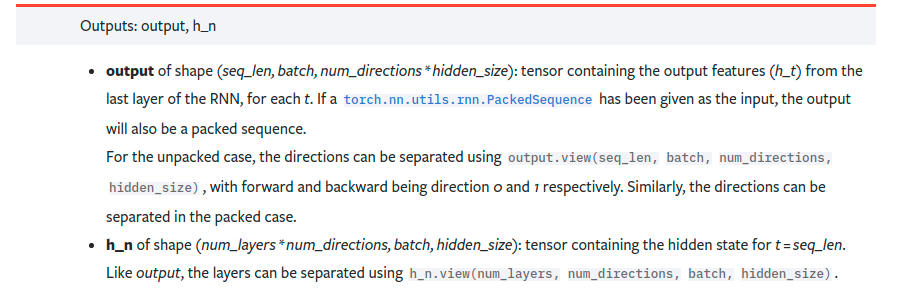

In [177]:
simple_elmo_gru = simpleGRU_model_w_elmo(elmo, INPUT_DIM, EMBEDDING_DIM, N_LAYERS, HID_DIM, OUTPUT_DIM)

In [178]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_elmo_gru.parameters(), lr = config['TRAIN']['LR'])

In [179]:
trg

tensor([12, 16, 14, 14])

In [180]:
def multi_acc(y_pred, y_test):
    _, y_pred_tags = torch.max(y_pred, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

In [181]:
output.max(dim = 1).indices 

tensor([2, 8])

In [182]:
output.shape

torch.Size([2, 17])

In [183]:
for batch in petition_dl:
    src, trg = batch.src_chr, batch.trg
    output =  simple_elmo_gru(src)
    loss = criterion(output, trg)
    print(output)
    print(output.max(dim=1).indices, trg)
    print(multi_acc(output, trg))
    loss.backward()
    optimizer.step()
    break


outpt torch.Size([2, 4, 512])
tensor([[ 0.0275,  0.0090,  0.0020,  0.2194, -0.0300,  0.0138,  0.0471,  0.1943,
         -0.0154,  0.2415, -0.1004, -0.0009,  0.1140,  0.0191,  0.0430,  0.1473,
          0.1366],
        [ 0.0243, -0.0023,  0.0094,  0.2089, -0.0352,  0.0061,  0.0325,  0.1864,
         -0.0252,  0.2349, -0.1106, -0.0113,  0.1212,  0.0215,  0.0416,  0.1627,
          0.1369],
        [ 0.0172,  0.0086, -0.0013,  0.1997, -0.0366,  0.0031,  0.0332,  0.2005,
         -0.0149,  0.2331, -0.1207, -0.0051,  0.1125,  0.0270,  0.0427,  0.1529,
          0.1243],
        [-0.0420,  0.0274, -0.0451,  0.1489, -0.1393, -0.0204,  0.0170,  0.2640,
          0.0639,  0.2648, -0.1616, -0.0569,  0.0667,  0.0343,  0.1268,  0.1016,
          0.1610]], grad_fn=<AddmmBackward>)
tensor([9, 9, 9, 9]) tensor([12, 16, 14, 14])
tensor(0.)


In [184]:
OUTPUT_DIM

17